In [1]:
!pwd

/Users/porrameth/GitHub/mcs999/my_llm/supervisor


In [8]:

#%cd /Users/porrameth/GitHub/udemy/llm_engineering/week5
%cd /Users/porrameth/GitHub/mcs999/my_llm/supervisor

/Users/porrameth/GitHub/mcs999/my_llm/supervisor


In [9]:
!pwd

/Users/porrameth/GitHub/mcs999/my_llm/supervisor


In [10]:
from typing import Annotated
import wikipedia
from langchain_core.tools import tool
import pandas as pd
import os


In [11]:
#!pip install yfinance
#
# !pip install ddgs

In [12]:
import yfinance as yf

@tool
def yfinance_tool(
    ticker: Annotated[str, "Ticker symbol, e.g., AAPL"],
    period: Annotated[str, "Data window (e.g., 5d, 1mo, 3mo, 1y, max)."] = "1mo",
    interval: Annotated[str, "Sampling interval (e.g., 1d, 1h, 5m)."] = "1d",
) -> str:
    """Fetch OHLCV price history with yfinance (no API key)."""
    try:
        df = yf.download(ticker, period=period, interval=interval, progress=False)
        if df.empty:
            return f"No data for {ticker}."
        head = df.tail(10).to_markdown()
        return f"Recent {ticker} data ({period}, {interval}):\n\n{head}"
    except Exception as e:
        return f"Failed to fetch prices. Error: {repr(e)}"


In [13]:
# from typing import Annotated
# from langchain_core.tools import tool

# Prefer the new package name `ddgs`, fall back to `duckduckgo_search`
try:
    from ddgs import DDGS
except ImportError:  # backward compatibility
    from duckduckgo_search import DDGS  # pip install duckduckgo-search

@tool
def ddg_search_tool(
    query: Annotated[str, "What to search for on the web."],
    max_results: Annotated[int, "Number of results to return."] = 5,
) -> str:
    """Search the web via DuckDuckGo (no API key). Returns a concise, readable list."""
    try:
        results = list(DDGS().text(query, max_results=max_results))
        if not results:
            return f"No results for: {query}"

        lines = []
        for r in results:
            title = (r.get("title") or "").strip()
            url = r.get("href") or ""
            snippet = (r.get("body") or "").strip()
            lines.append(f"- **{title}**\n  {url}\n  {snippet}")
        return f"DuckDuckGo results for **{query}**:\n" + "\n".join(lines)
    except Exception as e:
        return f"Search failed. Error: {repr(e)}"


In [14]:
# from typing import Annotated
# from langchain_core.tools import tool
from datetime import datetime
from zoneinfo import ZoneInfo  # Python 3.9+

TZ = ZoneInfo("Asia/Bangkok")

@tool
def now_tool(
    fmt: Annotated[str, "Optional strftime format, e.g. '%Y-%m-%d %H:%M'."] = ""
) -> str:
    """
    Return the current date/time in Asia/Bangkok.
    If fmt is provided, use it; otherwise return a friendly sentence.
    """
    now = datetime.now(TZ)
    return now.strftime(fmt) if fmt else now.strftime(
        "Today is %A, %B %d, %Y, and the time is %H:%M (%Z)."
    )


In [15]:
# from langchain_experimental.utilities import PythonREPL

# repl = PythonREPL()

# @tool
# def python_repl_tool(
#     code: Annotated[str, "The python code to execute to generate your chart."],
# ):
#     """Use this to execute python code. If you want to see the output of a value,
#     you should print it out with `print(...)`. This is visible to the user. The chart should be displayed using `plt.show()`."""
#     try:
#         result = repl.run(code)
#     except BaseException as e:
#         return f"Failed to execute. Error: {repr(e)}"
#     return f"Successfully executed the Python REPL tool.\n\nPython code executed:\n\`\`\`python\n{code}\n\`\`\`\n\nCode output:\n\`\`\`\n{result}\`\`\`"

# from typing import Annotated
# from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Create a Python REPL instance
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "Python code to execute. Use print(...) to show values and plt.show() to display charts."],
) -> str:
    """Run Python code in a REPL and return the output or error."""
    try:
        output = repl.run(code)
        return (
            "Python REPL executed successfully.\n\n"
            f"Code:\n```python\n{code}\n```\n\n"
            f"Output:\n```\n{output}\n```"
        )
    except Exception as e:
        return f"Execution failed. Error: {repr(e)}"


In [16]:
!ls

README                                 my_agent_exercise_supervisor-MOD.ipynb


In [17]:
from dotenv import load_dotenv
MODEL = "gpt-4o-mini"
#db_name = "vector_db"


load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [19]:
#os.environ['OPENAI_API_KEY']

In [20]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini")

# Research agent
research_agent = create_react_agent(
    llm,
    #tools=[wikipedia_tool, stock_data_tool],
    tools = [yfinance_tool,ddg_search_tool,now_tool],
    #tools = [yfinance_tool],
    prompt=(
#         "You are a research agent.\n\n"
#         "INSTRUCTIONS:\n"
#         "- Assist ONLY with research-related tasks, including looking-up factual information and stock data. DO NOT write any code.\n"
#         "- After you're done with your tasks, respond to the supervisor directly\n"
#         "- Respond ONLY with the results of your work, do NOT include ANY other text."
            "You are a research agent.\n\n"
             "GUIDELINES:\n"
            "- For any question about “today”, “current date/time”, or “now”, call `now_tool` instead of guessing.\n"
            "- Handle only research-oriented requests, such as retrieving factual information or stock market data. Do not write or generate code.\n"
            "- Once you complete your research, report your findings directly to the supervisor. \n"
            "- Your response must include only the research results. Do not add extra commentary or unrelated text. \n"

        
    ),
    name="researcher"
)

# Analyst agent
analyst_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=(
        # "You are an agent that can run arbitrary Python code.\n\n"
        # "INSTRUCTIONS:\n"
        # "- Assist ONLY with tasks that require running code to produce an output.\n"
        # "- After you're done with your tasks, respond to the supervisor directly\n"
        # "- Respond ONLY with the results of your work, do NOT include ANY other text."
        
        "You are an agent responsible for executing Python code.\n\n"
        "GUIDELINES: \n"
        "- Handle only requests that involve running code to generate an output.\n"
        "- Once execution is complete, report the results directly to the supervisor.\n"
        "- Provide only the output of your work, with no additional commentary or text."

        
    ),
    name="analyst"
)

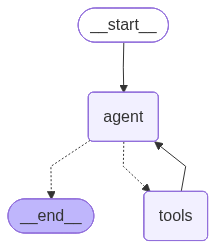

In [21]:
research_agent

In [22]:
from langgraph_supervisor import create_supervisor
from langgraph.checkpoint.memory import InMemorySaver

config = {"configurable": {"thread_id": "1", "user_id": "1"}}
checkpointer = InMemorySaver()

supervisor = create_supervisor(
    model=llm,
    agents=[research_agent, analyst_agent],
    prompt=(
        # "You are a supervisor managing two agents:\n"
        # "- a research agent. Assign research and data collection tasks to this agent\n"
        # "- an analyst agent. Assign the creation of visualizations via code to this agent\n"
        # "Assign work to one agent at a time, do not call agents in parallel.\n"
        # "Do not do any work yourself."
        
        "You are a supervisor overseeing two agents\n:"
"- The research agent: give this agent all tasks involving information lookup or data gathering.\n"
"- The analyst agent: give this agent tasks that require writing code to produce visualizations.\n"
"Always assign tasks to only one agent at a time; never run them in parallel.\n"
"Do not attempt to perform any of the tasks yourself."

        
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile(checkpointer=checkpointer)

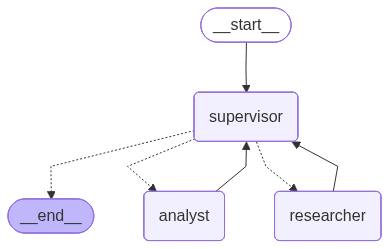

In [23]:
supervisor

In [24]:
## course_helper_functions.py
# from langchain_core.messages import convert_to_messages


# def pretty_print_message(message, indent=False):
#     pretty_message = message.pretty_repr(html=True)
#     if not indent:
#         print(pretty_message)
#         return

#     indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
#     print(indented)


# def pretty_print_messages(update, last_message=False):
#     is_subgraph = False
#     if isinstance(update, tuple):
#         ns, update = update
#         # skip parent graph updates in the printouts
#         if len(ns) == 0:
#             return

#         graph_id = ns[-1].split(":")[0]
#         print(f"Update from subgraph {graph_id}:")
#         print("\n")
#         is_subgraph = True

#     for node_name, node_update in update.items():
#         update_label = f"Update from node {node_name}:"
#         if is_subgraph:
#             update_label = "\t" + update_label

#         print(update_label)
#         print("\n")

#         messages = convert_to_messages(node_update["messages"])
#         if last_message:
#             messages = messages[-1:]

#         for m in messages:
#             pretty_print_message(m, indent=is_subgraph)
#         print("\n")
        
        
from langchain_core.messages import convert_to_messages

def pretty_print_message(message, indent: bool = False):
    """Print a single message, optionally indented."""
    # Prefer pretty_repr if available; fall back to str(message)
    if hasattr(message, "pretty_repr"):
        text = message.pretty_repr(html=True)
    else:
        text = str(message)

    if indent:
        text = "\n".join("\t" + line for line in text.split("\n"))

    print(text)


def pretty_print_messages(update, last_message: bool = False):
    """
    Print updates from nodes (and subgraphs) in a simple, readable format.

    Supports:
    - {"node": {"messages": [...]}, ...}
    - ((namespace,...), {"node": {"messages": [...]}, ...})  # subgraph updates
    """
    is_subgraph = False

    # Handle subgraph form: (namespace, update_dict)
    if isinstance(update, tuple) and len(update) == 2:
        ns, update = update
        # Skip parent graph updates (empty namespace)
        if not ns:
            return
        # Best-effort label for subgraph
        graph_id = str(list(ns)[-1]).split(":")[0] if ns else "unknown"
        print(f"Update from subgraph {graph_id}:\n")
        is_subgraph = True

    # Expect a dict of {node_name: {"messages": [...]}}
    if not isinstance(update, dict):
        print("(Unrecognized update payload)")
        print(update, "\n")
        return

    for node_name, node_update in update.items():
        print(("\t" if is_subgraph else "") + f"Update from node {node_name}:\n")

        # Safely get messages list
        msgs = []
        if isinstance(node_update, dict):
            msgs = node_update.get("messages", [])

        # Convert to LC messages (tolerate non-standard shapes)
        try:
            messages = convert_to_messages(msgs)
        except Exception:
            messages = msgs if isinstance(msgs, list) else [msgs]

        if last_message and messages:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)

        print()


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:

================================ Human Message =================================

Show graph of TSLA for the last 30 days price
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_analyst (call_yLtzWBOL2zKuAvr7GKMhFF3B)
 Call ID: call_yLtzWBOL2zKuAvr7GKMhFF3B
  Args:
================================= Tool Message =================================
Name: transfer_to_analyst

Successfully transferred to analyst



Python REPL can execute arbitrary code. Use with caution.
<string>:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed


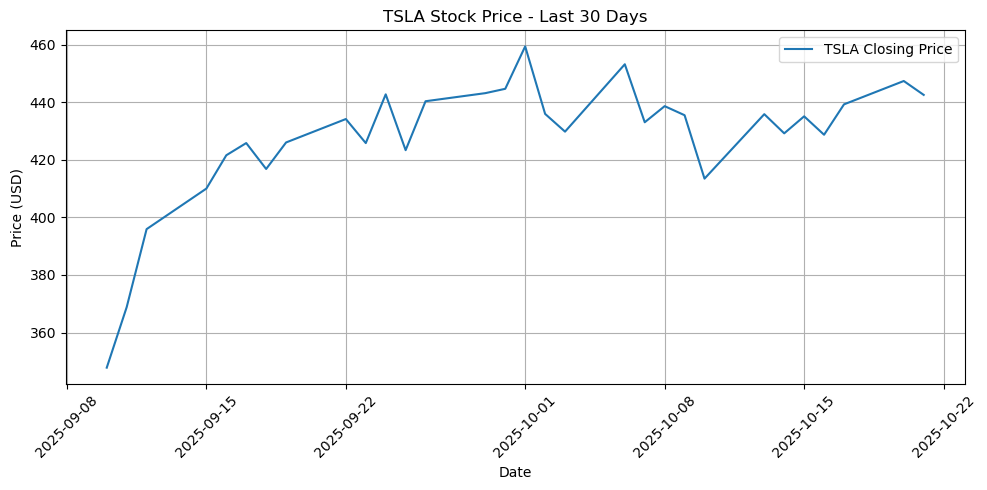

<string>:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed


Update from node analyst:

================================ Human Message =================================

Show graph of TSLA for the last 30 days price
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_analyst (call_yLtzWBOL2zKuAvr7GKMhFF3B)
 Call ID: call_yLtzWBOL2zKuAvr7GKMhFF3B
  Args:
================================= Tool Message =================================
Name: transfer_to_analyst

Successfully transferred to analyst
================================== Ai Message ==================================
Name: analyst
Tool Calls:
  python_repl_tool (call_VY9FPeXBN0bFtBdD3ek1ji5K)
 Call ID: call_VY9FPeXBN0bFtBdD3ek1ji5K
  Args:
    code: import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

# Get the last 30 days of TSLA stock data
symbol = 'TSLA'
data = yf.download(symbol, period='30d')

# Plotting the closing prices
plt.figure(figsize=(10,5))
plt.plot(data.index, data['Close'], label

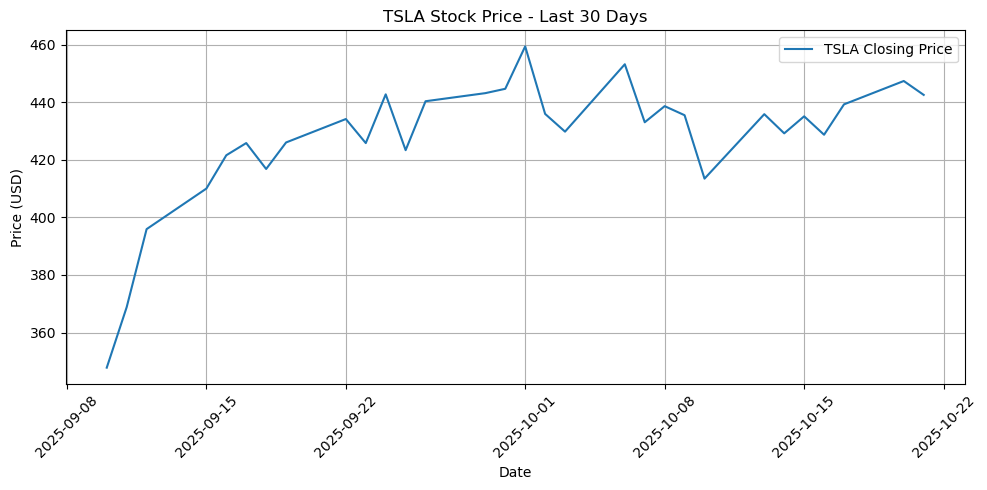

In [25]:
#from course_helper_functions import pretty_print_messages
import pprint

for chunk in supervisor.stream(
    #{"messages": [{"role": "user", "content": "Who is Apple's CEO?"}]}, config
    {"messages": [{"role": "user", "content": "Show graph of TSLA for the last 30 days price"}]}, config
    #{"messages": [{"role": "user", "content": "what's weather in Bangkok as of now ?"}]}, config
    #{"messages": [{"role": "user", "content": "what day is today"}]}, config
    #{"messages": [{"role": "user", "content": "list the temperature in Bangkok for the last 3 days"}]}, config
    #{"messages": [{"role": "user", "content": "show me the latest news about Trump "}]}, config

):
    pretty_print_messages(chunk)
    #pprint.pprint(chunk)
    

In [21]:
import gradio as gr

In [27]:
config = {"configurable": {"thread_id": "10"}}

async def chat(user_input: str, history):
    result = await supervisor.ainvoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()
# with gr.Blocks() as demo:
#     gr.Markdown("## Supervisor demo (streaming)")
#     with gr.Row():
#         txt = gr.Textbox(label="User prompt", placeholder="Show graph of TSLA for the last 30 days price", lines=2)
#         btn = gr.Button("Send")
#     with gr.Row():
#         out_text = gr.Textbox(label="Supervisor log (streaming)", lines=20)   # will be updated incrementally
#         out_image = gr.Image(label="Produced image (if any)")                 # optional image produced by analyst
#     btn.click(fn=chat, inputs=[txt], outputs=[out_text, out_image])

# demo.launch()

* Running on local URL:  http://127.0.0.1:7868

To create a public link, set `share=True` in `launch()`.


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.
/var/folders/r7/46wyby7515198gwmqnzxr6l40000gn/T/ipykernel_32978/363983337.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)
